## Initial setup
This analysis using ema is based on the work of Enayat A. Moallemi created on 22 May 2018 at the Fraunhofer ISI, Karlsruhe. In that instance, the analysis was done for the MATISSE model.
This notebook present a second stage on a SA and UA. It is a variance-based approach using the SOBOL. 
For this, The EMA workbench is used with SALib SOBOL sampler and SALib analyse methods.
    

In [13]:

'''
by Angela M. Rojas A. <angelara@student.unimelb.edu.au>

Created on February 2020

'''
import sys
import os

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
import os
import glob
import numpy as np
import pandas as pd
import os
import glob

includePlots = True

## SOBOL visualization functions
source code from [here](https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html) code-block 25

In [14]:
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, uncertainties, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15 #25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=uncertainties)

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=uncertainties,
                      columns=uncertainties)
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = uncertainties
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc='lower center', bbox_to_anchor=(1, 1), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})

## Load the results
These results are a tuple of one data frame with the changes on each input variable, and a dictionary with the outputs. 

In [15]:
from ema_workbench import load_results

#results = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_SOBOL2020ABY-Dec-23.tar.gz')
results = load_results(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/gr4sp_SOBOL2021-Feb-03.tar.gz')


In [16]:
experiments, outcomes = results
outcomes['PrimarySpot-WholesalePriceYear'] = outcomes['wholesalePriceYear']
# Create a temporary copy of dictionary, with Outcomes Year
outcomesYear = dict(outcomes)

keysToRemove = [] 
# Iterate over the temporary dictionary and delete corresponding key from original dictionary
for (key, value) in outcomesYear.items() :
    if 'Month' in key:
        keysToRemove.append(key)
        
for k in keysToRemove:        
    del outcomesYear[k]   
    
        

In [17]:
experiments.describe()

,annualCpi,annualInflation,consumption,domesticConsumptionPercentage,energyEfficiency,generationRolloutPeriod,generatorRetirement,importPriceFactor,includePublicallyAnnouncedGen,learningCurve,...,priceChangePercentageBrownCoal,priceChangePercentageOcgt,priceChangePercentageWater,priceChangePercentageWind,rooftopPV,scheduleMinCapMarketGen,semiScheduleGenSpotMarket,semiScheduleMinCapMarketGen,solarUptake,wholesaleTariffContribution
count,126000.000000,126000.000000,126000.000000,126000.000000,126000.000000,126000.000000,126000.000000,126000.000000,126000.000000,126000.000000,...,126000.000000,126000.000000,126000.000000,126000.000000,126000.000000,126000.000000,126000.000000,126000.000000,126000.000000,126000.000000
mean,3.000238,2.998810,1.999048,34.990000,1.000714,5.497143,-0.001429,-0.007143,0.500000,7.497143,...,-0.018333,0.006190,0.005000,0.000714,5.999524,150.541905,8.998333,150.370476,2.001429,27.503810
std,1.415313,1.415313,1.414556,8.939456,0.816645,2.872126,3.161913,29.152702,0.500002,4.609583,...,29.153567,29.154507,29.151743,29.152674,0.816208,86.593375,0.816061,86.599359,1.414892,10.387143
min,1.000000,1.000000,0.000000,20.000000,0.000000,1.000000,-5.000000,-50.000000,0.000000,0.000000,...,-50.000000,-50.000000,-50.000000,-50.000000,5.000000,1.000000,8.000000,1.000000,0.000000,10.000000
25%,2.000000,2.000000,1.000000,27.000000,0.000000,3.000000,-3.000000,-25.000000,0.000000,3.750000,...,-25.000000,-25.000000,-25.000000,-25.000000,5.000000,75.750000,8.000000,75.750000,1.000000,18.750000
50%,3.000000,3.000000,2.000000,35.000000,1.000000,5.500000,0.000000,0.000000,0.500000,7.500000,...,0.000000,0.000000,0.000000,0.000000,6.000000,150.500000,9.000000,150.500000,2.000000,27.500000
75%,4.000000,4.000000,3.000000,43.000000,2.000000,8.000000,3.000000,25.000000,1.000000,11.250000,...,25.000000,25.000000,25.000000,25.000000,7.000000,225.250000,10.000000,225.250000,3.000000,36.250000
max,5.000000,5.000000,4.000000,50.000000,2.000000,10.000000,5.000000,50.000000,1.000000,15.000000,...,50.000000,50.000000,50.000000,50.000000,7.000000,300.000000,10.000000,300.000000,4.000000,45.000000


## Uncertainties/levers

The outcomes are shown per year. Though another analysis can be done for monthly outcomes. 

In [27]:
outcomes_to_show = ['consumptionYear', 'tariffsYear', 'PrimarySpot-WholesalePriceYear', 'GHGYear', 
                    'primarySpotProductionYear', 'secondarySpotProductionYear', 
                    'offSpotProductionYear', 'renewableContributionYear', 'rooftopPVProductionYear', 
                    'coalProductionYear', 'waterProductionYear', 'windProductionYear', 'gasProductionYear', 
                    'solarProductionYear', 'primaryUnmetDemandMwh', 
                    'primaryUnmetDemandHours', 'primaryUnmetDemandDays', 'primaryMaxUnmetDemandMwhPerHour', 
                    'secondaryUnmetDemandMwh', 'secondaryUnmetDemandHours', 'secondaryUnmetDemandDays', 
                    'secondaryMaxUnmetDemandMwhPerHour']
outcomes_to_show = ['GHGYear', 'renewableContributionYear', 'PrimarySpot-WholesalePriceYear', 'tariffsYear']


# 23 levers/uncertainties selected after EET (last test July 2020)
# 25 uncertainties selected aftet EET including change on domestic demand and unmet demand output (August 2020)
# 26 uncertainties selected after EET for changes afterBaseYear(Dec 2020)
uncertainties = experiments.columns[:-3]

#from startYear
startYear = 2019
startYearShift = (startYear - 1998)
#startYearShift = (startYear - 1997) * 12
time = outcomes['TIMEYear'][0, startYearShift:]
#index = pd.to_datetime(time, format = '%Y-%m-%d')
index = pd.to_datetime(time, format = '%Y')

In [28]:
for n in uncertainties:
    var = experiments[n]
    val = np.unique(var)
    print("{}: {}".format(n,val))

annualCpi: [1. 2. 3. 4. 5.]
annualInflation: [1. 2. 3. 4. 5.]
consumption: [0. 1. 2. 3. 4.]
domesticConsumptionPercentage: [20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]
energyEfficiency: [0. 1. 2.]
generationRolloutPeriod: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
generatorRetirement: [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
importPriceFactor: [-50. -49. -48. -47. -46. -45. -44. -43. -42. -41. -40. -39. -38. -37.
 -36. -35. -34. -33. -32. -31. -30. -29. -28. -27. -26. -25. -24. -23.
 -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.
  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.
   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.
  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.
  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  50.]
includePublicallyAnnouncedGen: [0. 1.]
learningCurve: 

 295. 296. 297. 298. 299. 300.]
semiScheduleGenSpotMarket: [ 8.  9. 10.]
semiScheduleMinCapMarketGen: [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.
 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154.
 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168.
 169. 170. 171. 172. 173. 174. 175. 176. 177. 

## SOBOL
To obtain the SALib results for each input for the sobol sensitivity indices (S1, S2, and ST)

In [29]:
from gr4spModelSOBOL import getModelAFterBaseYear
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import determine_parameters
from EMAworkbench.ema_workbench import (IntegerParameter, RealParameter, CategoricalParameter, BooleanParameter)

model = getModelAFterBaseYear()
uncertaintyCategories = determine_parameters(model, 'uncertainties', union=False) 
problem = get_SALib_problem(uncertaintyCategories)

In [30]:
def isclose(a, b, rel_tol=1e-09):
    return abs(a-b) <= rel_tol 

from SALib.analyze import sobol

sobol_stats_years_ooi = {}
s1_years_ooi = {}
s1_conf_years_ooi = {}
st_years_ooi = {}
st_conf_years_ooi = {}
s2_years_ooi = {}
s2_conf_years_ooi = {}
num_uncertainties = len(uncertainties)
print(num_uncertainties)
for ooi in outcomes_to_show:
    sobol_stats_years = pd.DataFrame([],columns=uncertainties)
    s1_years = pd.DataFrame([],columns=uncertainties)
    s1_conf_years = pd.DataFrame([],columns=uncertainties)
    st_years = pd.DataFrame([],columns=uncertainties)
    st_conf_years = pd.DataFrame([],columns=uncertainties)
    s2_years = {}
    s2_conf_years = {}
    for t in range(startYearShift, startYearShift + len(time)):
        dataY = outcomes[ooi][:, t]
        #change num_uncertainties = p to do the analysis with p levels
        stdY = dataY.std()
        print("{} - std: {}".format(startYear+t-startYearShift, stdY ) )

        if isclose(stdY, 0.0, rel_tol=1e-9):
            sobol_indices = {}
            sobol_indices['ST'] = np.zeros( num_uncertainties )
            sobol_indices['ST_conf'] = np.zeros( num_uncertainties )
            sobol_indices['S1'] = np.zeros( num_uncertainties )
            sobol_indices['S1_conf'] = np.zeros( num_uncertainties )
            sobol_indices['S2'] = np.zeros( (num_uncertainties, num_uncertainties) )
            sobol_indices['S2_conf'] = np.zeros( (num_uncertainties, num_uncertainties) )
        else:
            sobol_indices = sobol.analyze(problem, dataY, num_resamples=1000)
        
        sobol_stats = {key: sobol_indices[key] for key in ['ST', 'ST_conf', 'S1',
                                                       'S1_conf']}
        
        sobol_stats = pd.DataFrame(sobol_stats, index=uncertainties)
        sobol_stats.sort_values(by='ST', ascending=False)
        s1 = pd.DataFrame([sobol_indices['S1']], columns=uncertainties)
        s1_conf = pd.DataFrame([sobol_indices['S1_conf']], columns=uncertainties)
        st = pd.DataFrame([sobol_indices['ST']], columns=uncertainties)
        st_conf = pd.DataFrame([sobol_indices['ST_conf']], columns=uncertainties)
        s2 = pd.DataFrame(sobol_indices['S2'], index=uncertainties, columns=uncertainties)
        s2_conf = pd.DataFrame(sobol_indices['S2_conf'], columns=uncertainties)
        
        sobol_stats_years = sobol_stats_years.append(sobol_stats, sort=False)
        s1_years = s1_years.append(s1, sort=False)
        s1_conf_years = s1_conf_years.append(s1_conf, sort=False)
        st_years = st_years.append(st, sort=False)
        st_conf_years = st_conf_years.append(st_conf, sort=False)
        s2_years[startYear] = s2
        s2_conf_years[startYear+t] = s2_conf
    
    s1_years = s1_years.set_index(time)        
    s1_conf_years = s1_conf_years.set_index(time)
    st_years = st_years.set_index(time)
    st_conf_years = st_conf_years.set_index(time)

    
    sobol_stats_years_ooi[ooi] = sobol_stats_years
    s1_years_ooi[ooi] = s1_years
    s1_conf_years_ooi[ooi] = s1_conf_years
    st_years_ooi[ooi] = st_years
    st_conf_years_ooi[ooi] = st_conf_years
    s2_years_ooi[ooi] = s2_years
    s2_conf_years_ooi[ooi] = s2_conf_years
    print(ooi)
    #break
    


29
2019 - std: 1.6402997907473729
2020 - std: 1.66804306736043
2021 - std: 1.5939790501217699
2022 - std: 1.6481995843884243
2023 - std: 1.6737762080490912
2024 - std: 1.7000915755755535
2025 - std: 1.6929771207944508
2026 - std: 1.663470330170389
2027 - std: 1.6301812415554349
2028 - std: 1.6012206721027293
2029 - std: 1.5644967975193549
2030 - std: 1.5311115299207345
2031 - std: 1.4992591894309568
2032 - std: 1.4681636649196463
2033 - std: 1.4267230140170162
2034 - std: 1.387914514094417
2035 - std: 1.3539579797591252
2036 - std: 1.3324965613817072
2037 - std: 1.3118452966067677
2038 - std: 1.3107790684528904
2039 - std: 1.3040645094797636
2040 - std: 1.2283924236101864
2041 - std: 1.2250479057962023
2042 - std: 1.2075377425453537
2043 - std: 1.2723042863865694
2044 - std: 1.3233354056816597
2045 - std: 1.3874582524708448
2046 - std: 1.461592405529377
2047 - std: 1.4631562565162946
2048 - std: 1.4181674180239754
2049 - std: 1.380356591916927
2050 - std: 1.3220507009630953
GHGYear
201

### Median and Max S1,ST,S2 and confidence intervals for all years in data frame

In [31]:
s1_median_ooi = {}
s1_max_val_ooi = {}
s1_max_val_year_ooi = {}
s1_conf_median_ooi = {}
s1_conf_max_val_ooi = {}
s2_median_ooi = {}
s2_max_val_ooi = {}
s2_conf_median_ooi = {}
s2_conf_max_val_ooi = {}
st_median_ooi = {}
st_max_val_ooi = {}
st_max_val_year_ooi = {}
st_conf_median_ooi = {}
st_conf_max_val_ooi = {}

ntime = len(time)
for ooi in outcomes_to_show:
    
    s1_median_ooi[ooi] = s1_years_ooi[ooi].median()    
    s1_max_val_ooi[ooi] = s1_years_ooi[ooi].max()
    s1_max_val_year_ooi[ooi] = s1_years_ooi[ooi].idxmax()
    s1_conf_max_val_ooi[ooi] = pd.Series({ k: s1_conf_years_ooi[ooi].loc[v,k] for k, v in s1_max_val_year_ooi[ooi].items()})
    st_median_ooi[ooi] = st_years_ooi[ooi].median()
    st_max_val_ooi[ooi] = st_years_ooi[ooi].max()
    st_max_val_year_ooi[ooi] = st_years_ooi[ooi].idxmax()
    st_conf_median_ooi[ooi] = st_conf_years_ooi[ooi].median()
    st_conf_max_val_ooi[ooi] = pd.Series({ k: st_conf_years_ooi[ooi].loc[v,k] for k, v in st_max_val_year_ooi[ooi].items()})
    
    s1_conf_median = {}
    for c in s1_years_ooi[ooi].columns:
        dist = 1
        for i in s1_years_ooi[ooi].index:        
            if dist > abs(s1_years_ooi[ooi].loc[i,c] - s1_median_ooi[ooi][c]):
                dist = abs(s1_years_ooi[ooi].loc[i,c] - s1_median_ooi[ooi][c])
                s1_conf_median[c] = s1_conf_years_ooi[ooi].loc[i,c]

        s1_conf_median_ooi[ooi] = pd.Series(s1_conf_median)

    st_conf_median = {}
    for c in st_years_ooi[ooi].columns:
        dist = 1
        for i in st_years_ooi[ooi].index:        
            if dist > abs(st_years_ooi[ooi].loc[i,c] - st_median_ooi[ooi][c]):
                dist = abs(st_years_ooi[ooi].loc[i,c] - st_median_ooi[ooi][c])
                st_conf_median[c] = st_conf_years_ooi[ooi].loc[i,c]

    st_conf_median_ooi[ooi] = pd.Series(st_conf_median)

    s2_max_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_val in s2_years_ooi[ooi].items():
        columns = list(s2_val) 
        for i in columns:
            for j in range(num_uncertainties):
                if s2_max_val[i][j] < s2_val[i][j]:
                    s2_max_val[i][j] = s2_val[i][j]
    s2_max_val_ooi[ooi] = s2_max_val

    s2_conf_max_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_conf_val in s2_conf_years_ooi[ooi].items():
        columns = list(s2_conf_val) 
        for i in columns:
            for j in range(num_uncertainties):
                if s2_conf_max_val[i][j] < s2_conf_val[i][j]:
                    s2_conf_max_val[i][j] = s2_conf_val[i][j]
    s2_conf_max_val_ooi[ooi] = s2_conf_max_val    

    s2_median_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_val in s2_years_ooi[ooi].items():
        columns = list(s2_val) 
        for i in columns:
            for j in range(num_uncertainties):                
                    s2_median_val[i][j] += s2_val[i][j]
                    if time[-1] == year:
                        s2_median_val[i][j] /= ntime
    s2_median_ooi[ooi] = s2_median_val
    
    s2_conf_median_val = pd.DataFrame(np.zeros((num_uncertainties, num_uncertainties)), index=uncertainties, columns=uncertainties)
    for year, s2_conf_val in s2_conf_years_ooi[ooi].items():
        columns = list(s2_conf_val) 
        for i in columns:
            for j in range(num_uncertainties):                
                    s2_conf_median_val[i][j] += s2_conf_val[i][j]
                    if time[-1] == year:
                        s2_conf_median_val[i][j] /= ntime
    s2_conf_median_ooi[ooi] = s2_conf_median_val
    

### Bar plots of s1,st,s2,s2_conf 
source code from [here](https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html) code-block 21 

In [32]:
def plot_scores_2(df, ooi):
       # take 2 dfs, for 2050 and for 2100 values
       # make a grid of two axes
       # keep the y axis according to 2050, align 2100 accordingly
    #make a combined indices df to ensure index match
    
#     mergedind = inds1.merge(inds2, left_index=True, right_index=True, how='inner')
#     mergederr = err1.merge(err2, left_index=True, right_index=True, how='inner')
    
    sns.set_style('white')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 10)) 
    plt.subplots_adjust(wspace=0.1)
    ax = axes[0]
    ind = df[['S1_median','ST_median']]
    err = df[['S1_conf_median','ST_conf_median']]
    ind.plot.barh(xerr=err.values.T,ax=ax, color = ['darkorange', 'cornflowerblue'], width=.8)
    ax.set_ylabel('')
    ax.legend().set_visible(False)
    ax.set_xlabel('Sobol index', fontsize=14)

    ylabels = ax.get_yticklabels()
    ylabels = [item.get_text()[:] for item in ylabels]
    ax.set_yticklabels(ylabels, fontsize=12)
    ax.set_title("Median", fontsize=12)
    
    ax = axes[1]
    ind = df[['S1_max','ST_max']]
    err = df[['S1_conf_max','ST_conf_max']]
    ind.plot.barh(xerr=err.values.T,ax=ax, color = ['darkorange', 'cornflowerblue'], width=.8)
    #ax.set_xlim(axes[0].get_xlim())
    ax.set_ylabel('')
    ax.set_xlabel('Sobol index', fontsize=14)
    ax.set_yticklabels([])
    ax.set_title("Maximum", fontsize=12)
    for p, label, s1, st, s1_conf, st_conf in zip(axes[1].patches, ylabels, ind['S1_max'],ind['ST_max'], err['S1_conf_max'],err['ST_conf_max']):
        if p.get_width() >= 0.1: #to include all years use =! 0
            #print(s1,s1_conf, st, st_conf, p.get_width(),p.get_x(), p.get_y())
            axes[1].annotate(str(st_max_val_year_ooi[ooi][label]), (p.get_x() + st + st_conf/2.0 + 0.08, p.get_y() + p.get_height() + .05) ,fontsize=12,  rotation='horizontal')
            axes[1].annotate(str(s1_max_val_year_ooi[ooi][label]), (p.get_x() + s1 + s1_conf/2.0 + 0.08, p.get_y() - .05) ,fontsize=12, rotation='horizontal')

    handles,labels = ax.get_legend_handles_labels()
    handles = [handles[1], handles[0]]
    #labels = [labels[1], labels[0]]
    labels = ['ST', 'S1']
    ax.legend(handles,labels,fontsize=14,markerscale=2,loc='lower right')
    
    plt.suptitle("Sobol Sensitivity Indices for {}".format(ooi), y=0.94, fontsize=14)
    plt.rcParams["figure.figsize"] = [7.08,7.3]
    plt.savefig(r'{}/Sobol_barplo_rank{}.pdf'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', ooi), dpi=600,  bbox_inches='tight')        
    plt.savefig(r'{}/Sobol_barplo_rank{}.eps'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', ooi), dpi=600,  bbox_inches='tight')
    return fig

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


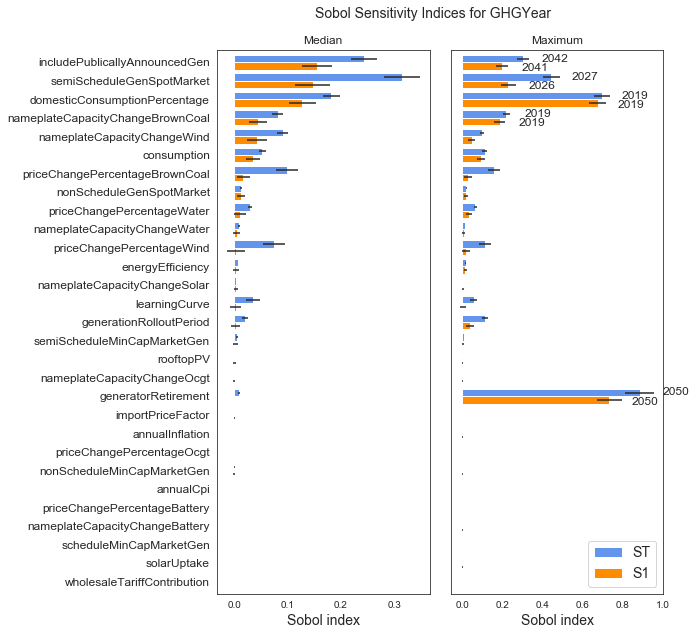

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


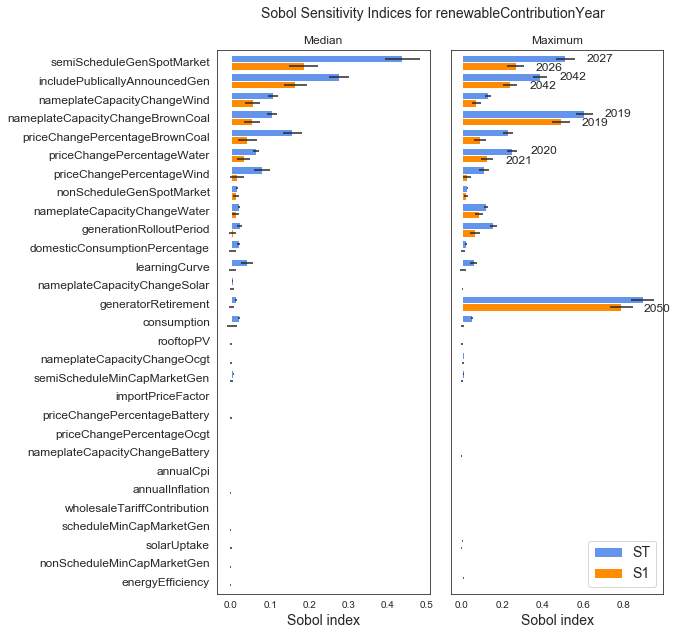

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


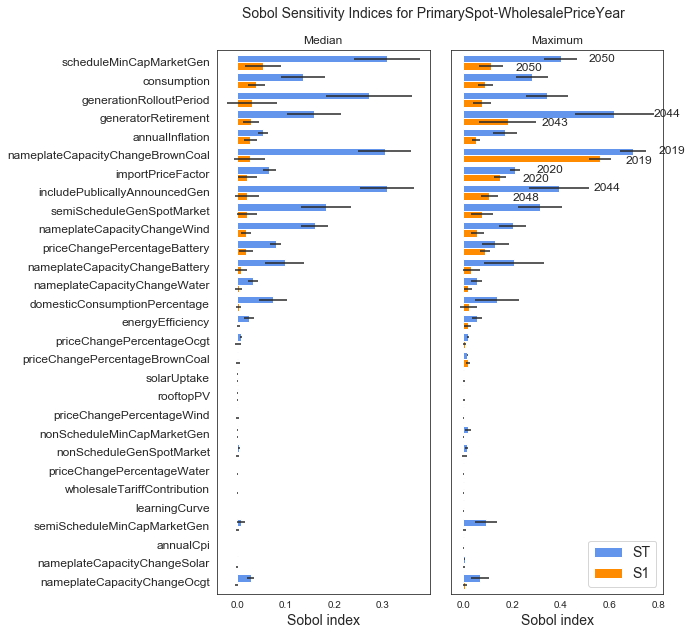

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


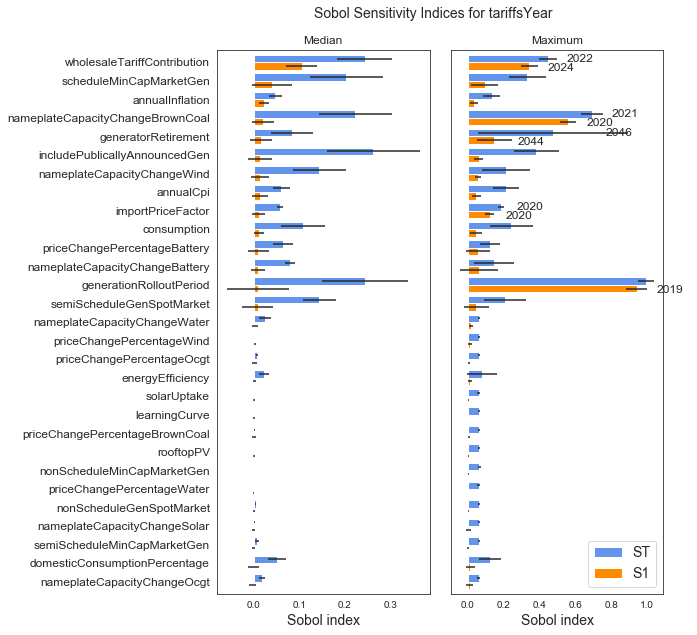

In [33]:
for ooi in outcomes_to_show:
    
    Si_df = pd.concat({'S1_median': s1_median_ooi[ooi],'ST_median': st_median_ooi[ooi], 'S1_conf_median': s1_conf_median_ooi[ooi],'ST_conf_median': st_conf_median_ooi[ooi], 'S1_max': s1_max_val_ooi[ooi],'ST_max': st_max_val_ooi[ooi],'S1_conf_max': s1_conf_max_val_ooi[ooi],'ST_conf_max': st_conf_max_val_ooi[ooi]}, axis=1)
    Si_df.sort_values(by=['S1_median'], ascending=True, inplace=True)    
    
    if includePlots:
        plot_scores_2(Si_df, ooi)
        plt.show()


GHGYear
renewableContributionYear
PrimarySpot-WholesalePriceYear
tariffsYear


PermissionError: [Errno 13] Permission denied: 'C:\\\\Users\\\\angel\\\\Documents\\\\GitHub\\\\gr4sp\\\\experiments\\\\notebookGr4sp\\\\outputs\\\\data/SOBOL__median_sensitivity_Indices.xlsx'

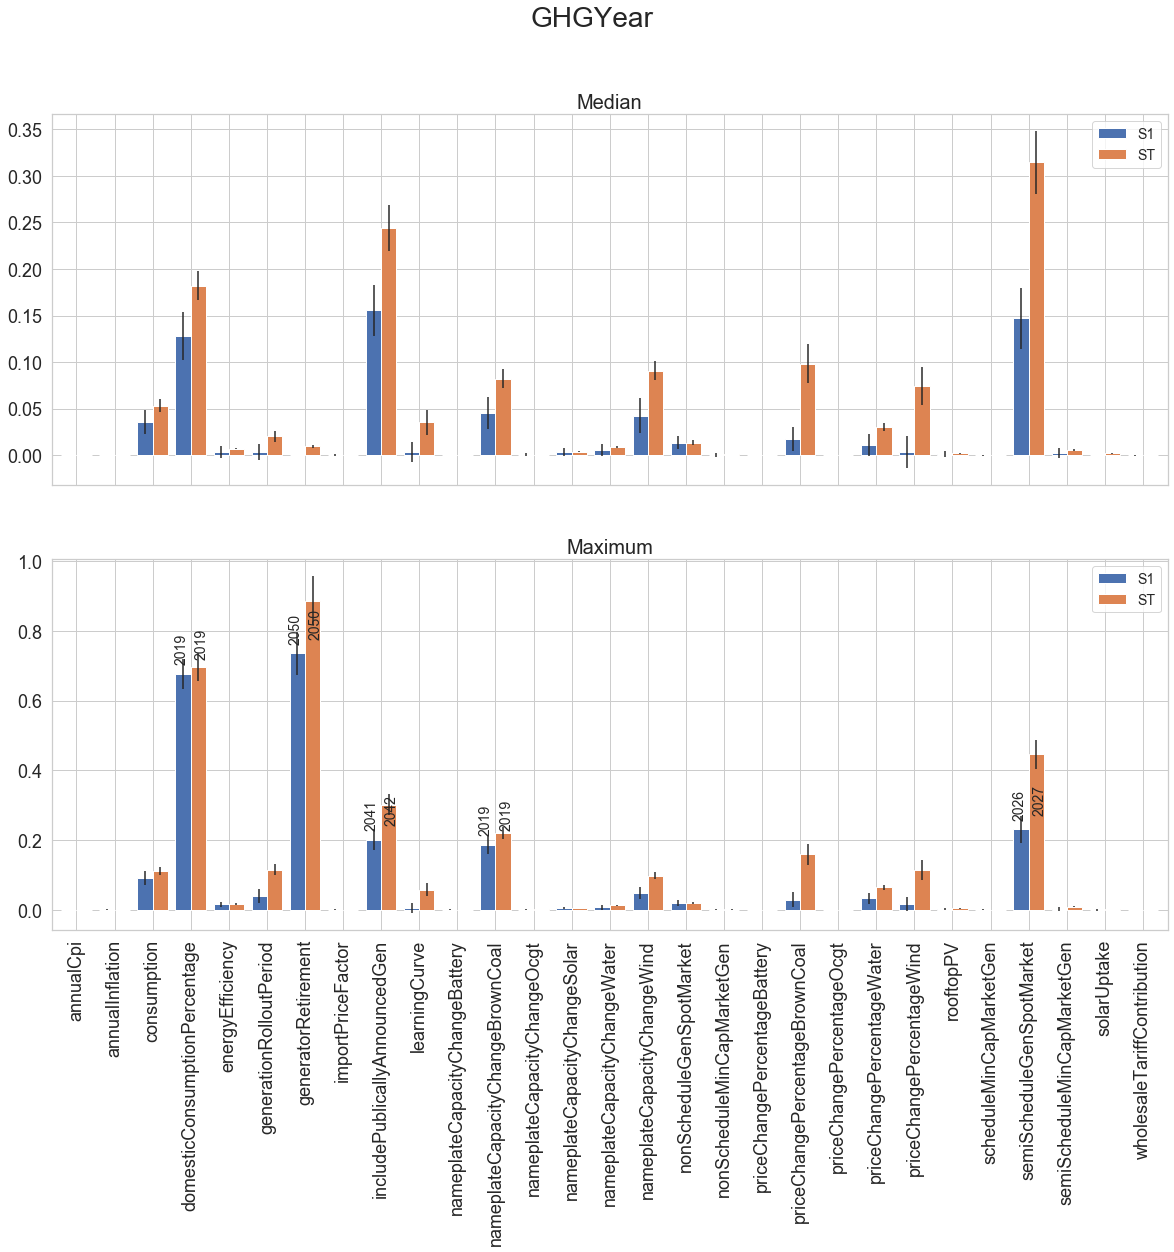

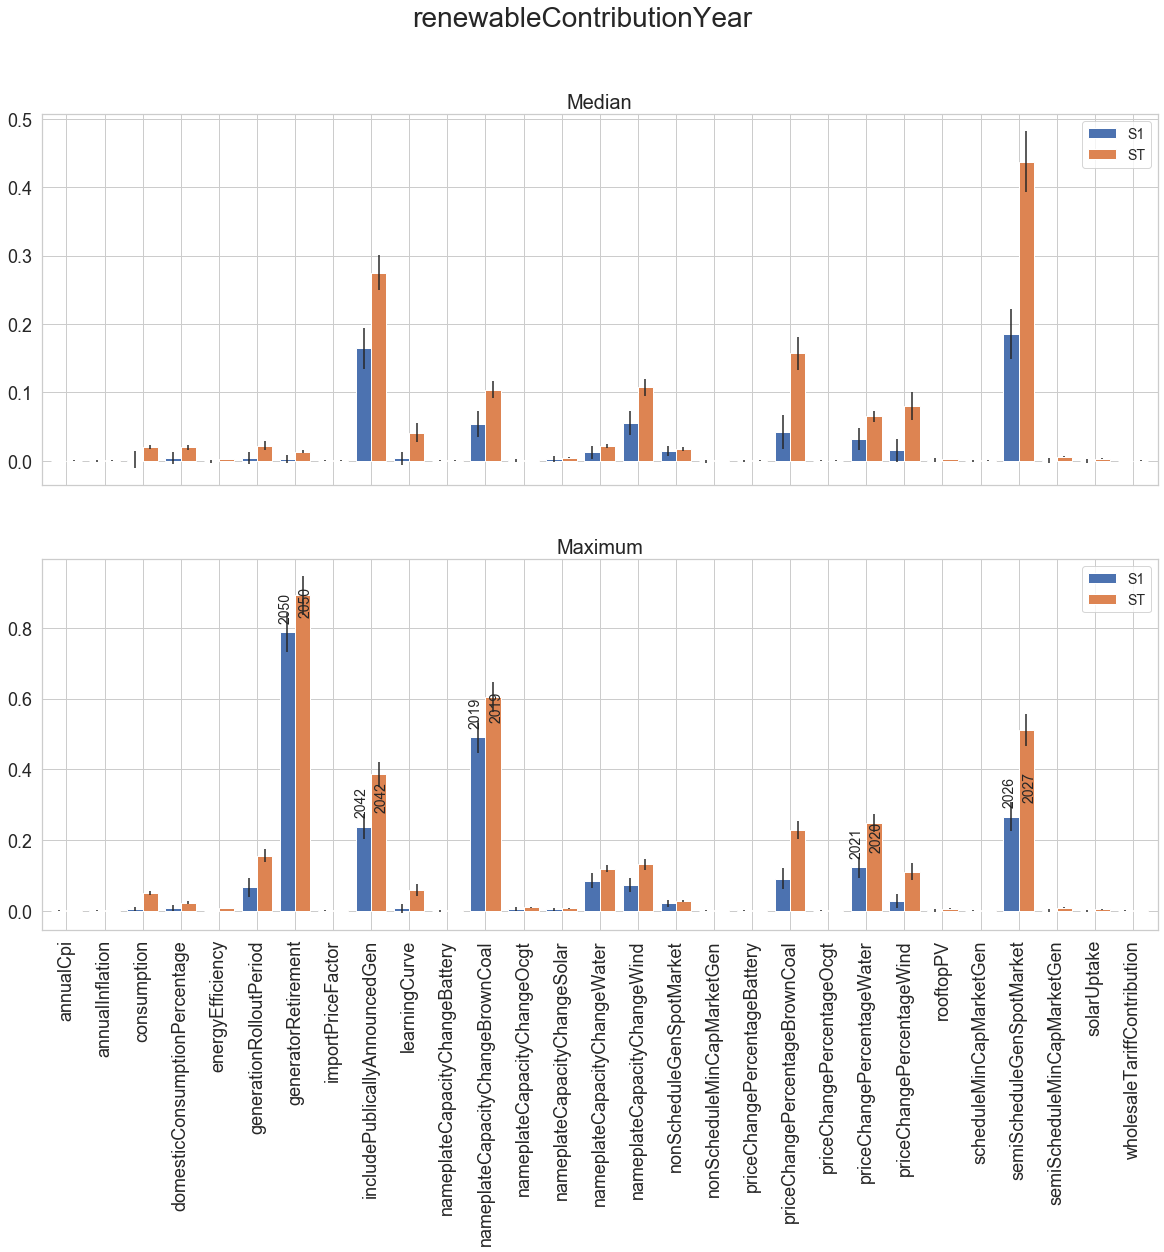

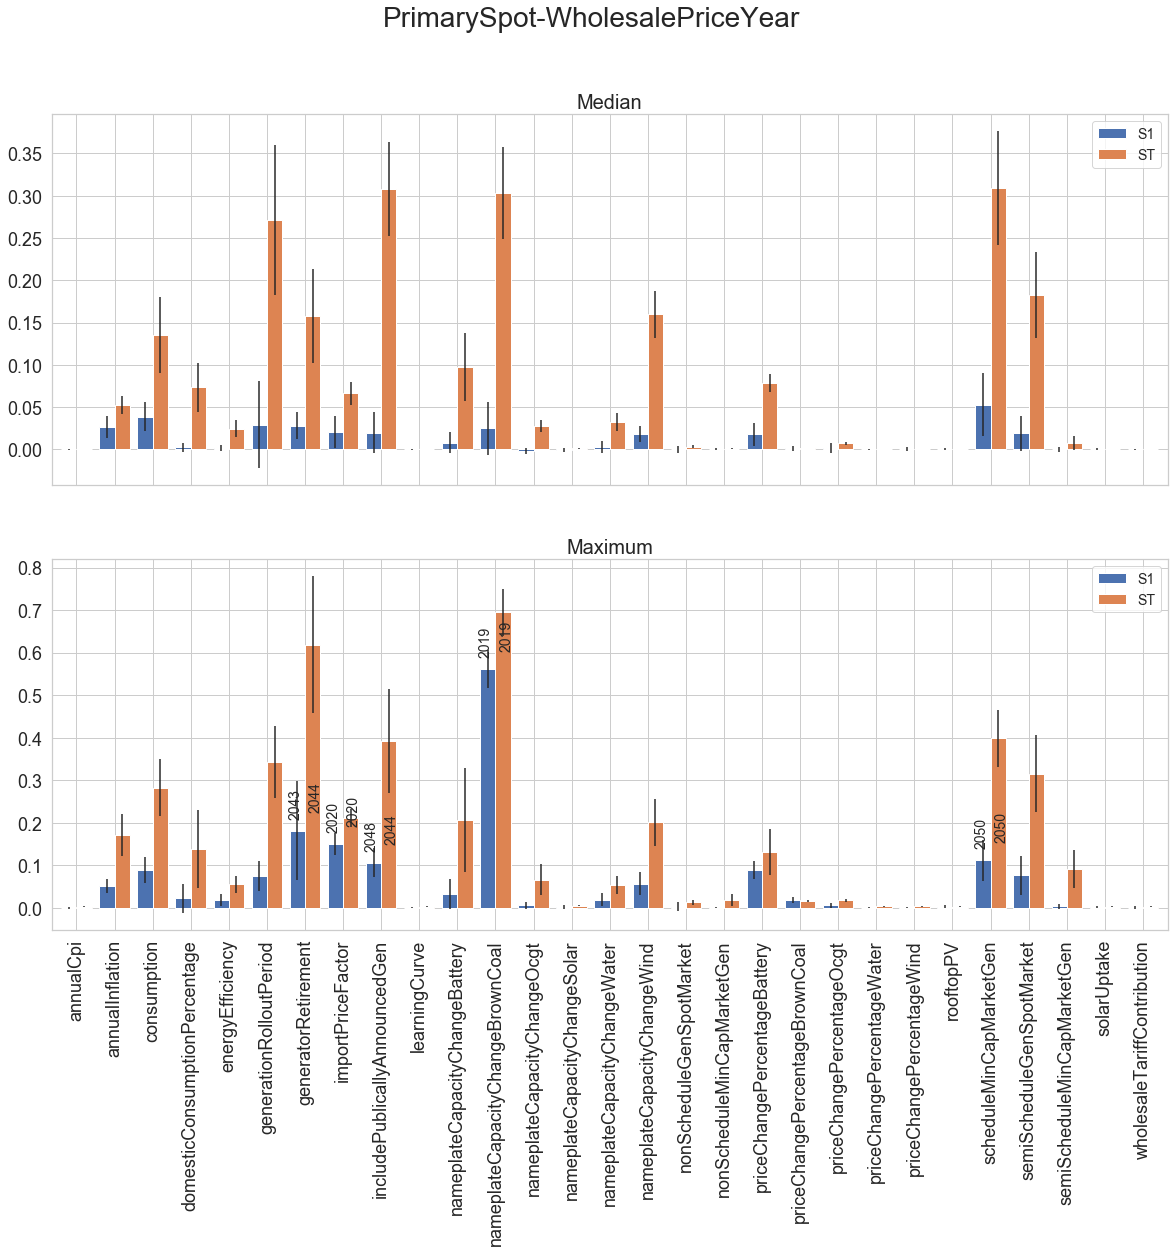

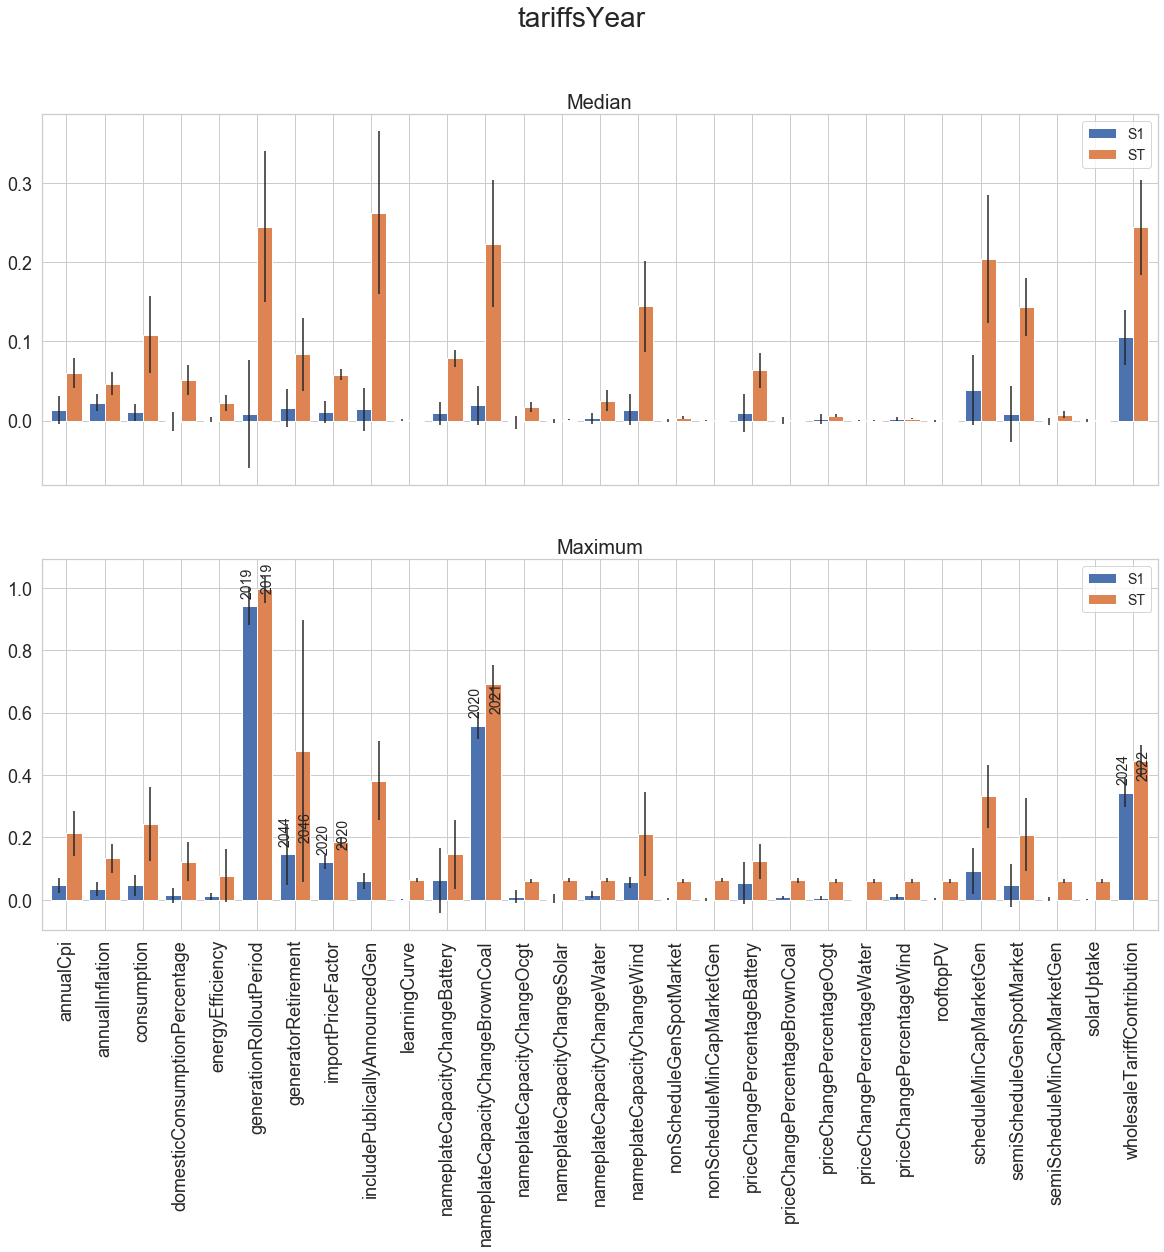

In [34]:
import seaborn as sns; sns.set_theme();sns.set_style("whitegrid")

writer = pd.ExcelWriter('{}/SOBOL_{}.xlsx'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\data', '_median_sensitivity_Indices'), engine='xlsxwriter')

#f = plt.figure(figsize=(20,30)) 
for ooi in outcomes_to_show:
    
    Si_df_median = pd.concat({'S1': s1_median_ooi[ooi],'ST': st_median_ooi[ooi], 'S2': s2_median_ooi[ooi],'S1_conf': s1_conf_median_ooi[ooi],'ST_conf': st_conf_median_ooi[ooi], 'S2_conf': s2_conf_median_ooi[ooi]}, axis=1)
    Si_df_max = pd.concat({'S1': s1_max_val_ooi[ooi],'ST': st_max_val_ooi[ooi], 'S2': s2_max_val_ooi[ooi],'S1_conf': s1_conf_max_val_ooi[ooi],'ST_conf': st_conf_max_val_ooi[ooi], 'S2_conf': s2_conf_max_val_ooi[ooi]}, axis=1)
    sortMedian = Si_df_median.sort_values
    
    if includePlots:
        fig, ax = plt.subplots(2, sharex=True)
        fig.set_size_inches(20,15)
        fig.suptitle(ooi, fontsize=28)

        ax[0].set_title("Median", fontsize=20)
        ax[1].set_title("Maximum", fontsize=20)

        plt.xticks (fontsize = 18)
        plt.yticks (fontsize = 18)
        ax[0].tick_params(labelsize=18)

        indices_median = Si_df_median[['S1','ST']]
        err_median = Si_df_median[['S1_conf','ST_conf']]

        indices_max = Si_df_max[['S1','ST']]
        err_max = Si_df_max[['S1_conf','ST_conf']]

        indices_median.plot.bar(yerr=err_median.values.T,ax=ax[0], width=0.8)
        indices_max.plot.bar(yerr=err_max.values.T,ax=ax[1], width = 0.8)
        for p, text_s1, text_st in zip(ax[1].patches, s1_max_val_year_ooi[ooi], st_max_val_year_ooi[ooi]):
            if p.get_height() >= 0.1: #to include all years use =! 0
                ax[1].annotate(str(text_s1), (p.get_x() - 0.03, p.get_height() + .035) ,fontsize=14, rotation='vertical')
                ax[1].annotate(str(text_st), (p.get_x() + 0.5, p.get_height() + .05) ,fontsize=14,  rotation='vertical')
                               
        ax[0].legend(['S1','ST'], fontsize=14)
        ax[1].legend(['S1','ST'], fontsize=14)
    
        #break
        
        plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_barplot_s1_st_%s'%(ooi)),dpi=300, bbox_inches='tight')
        
    print(ooi)
    
    if ooi == 'secondaryMaxUnmetDemandMwhPerHour':
        ooi = 'secondMaxUnmetMwhPerHour'
        
    Si_df_median.to_excel(writer, sheet_name=ooi)

    
    

writer.save()

### S2, S1, and ST plots

In [ ]:
# #%matplotlib inline
# sns.set_style('whitegrid')
# if includePlots:
#     for ooi in outcomes_to_show:

#         #Maximum
#         Si_df_max = {'S1': s1_max_val_ooi[ooi].to_numpy(),'S2': s2_max_val_ooi[ooi].to_numpy(),
#                      'ST': st_max_val_ooi[ooi].to_numpy(),'S1_conf': s1_conf_max_val_ooi[ooi].to_numpy(),
#                      'S2_conf': s2_conf_max_val_ooi[ooi].to_numpy(),'ST_conf': st_conf_max_val_ooi[ooi].to_numpy()}

#         fig = plot_sobol_indices(Si_df_max, uncertainties, criterion='ST', threshold=0.005)
#         fig.set_size_inches(20,15)
#         fig.suptitle(ooi)   

#         plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sobol_max_%s'%(ooi)),dpi=300, bbox_inches='tight')

#         #Median
#         Si_df_avg = {'S1': s1_median_ooi[ooi].to_numpy(),'S2': s2_median_ooi[ooi].to_numpy(),
#                      'ST': st_median_ooi[ooi].to_numpy(),'S1_conf': s1_conf_median_ooi[ooi].to_numpy(),
#                      'S2_conf': s2_conf_median_ooi[ooi].to_numpy(),'ST_conf': st_conf_median_ooi[ooi].to_numpy()}

#         fig = plot_sobol_indices(Si_df_median, uncertainties, criterion='ST', threshold=0.005)
#         fig.set_size_inches(20,15)
#         fig.suptitle(ooi, fontsize=16)   



#         plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sobol_median_%s'%(ooi)),dpi=300, bbox_inches='tight')

#         print(ooi)
     

## S2

In [ ]:
sns.set_style("white")
includePlots=True
#change colorpalette: https://seaborn.pydata.org/generated/seaborn.diverging_palette.html and https://colorbrewer2.org/#type=diverging&scheme=PiYG&n=3

if includePlots:
    for ooi in outcomes_to_show:
        corr = s2_median_ooi[ooi]
        corr = corr.round(3)

        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9))

        # Generate a custom diverging colormap
        #cmap = sns.diverging_palette(247,160, as_cmap=True, center = "light")
        #cmap = sns.color_palette("coolwarm", as_cmap=True)
        cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light")
        # Draw the heatmap
        sns.heatmap(corr.T, cmap=cmap, vmin=corr.min(axis=1).min(),vmax=corr.max(axis=1).max(), center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})
        f.suptitle(ooi, fontsize=18)
        plt.savefig('{}/fig{}.png'.format(r'C:\\Users\\angel\\Documents\\GitHub\\gr4sp\\experiments\\notebookGr4sp\\outputs\\figs', '_sobol_s2_median_%s'%(ooi)),dpi=300, bbox_inches='tight')
        #break

        